In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)

## Preprocessing

In [52]:
setwd("/group/gilbert-lab/Lutz/Cadaver/phyloseq_files_30June2018/")

biom <- import_biom("3813_4522_4885.biom")
map <- import_qiime_sample_data("metadata_for_phyloseq_30June2018.txt")
tree <- read_tree("rep_phylo.tre")
cadaver_nt <- merge_phyloseq(biom,tree,map)
cadaver_nt <- prune_samples(sample_sums(cadaver_nt) > 1000, cadaver_nt)
cadaver <- merge_phyloseq(biom,tree,map) %>%
    prune_samples((sample_sums(.) > 1000), .) %>%
    filter_taxa(function(x) sum(x > 3) > (0.001*length(x)), TRUE) %>%
    transform_sample_counts(function(x) x / sum(x))

cadaver_nt = subset_samples(cadaver_nt, The.manner.of.death=="Accident"|The.manner.of.death=="Homicide"|The.manner.of.death=="Natural"|The.manner.of.death=="Suicide")
cadaver = subset_samples(cadaver, The.manner.of.death=="Accident"|The.manner.of.death=="Homicide"|The.manner.of.death=="Natural"|The.manner.of.death=="Suicide")

saveRDS(cadaver_nt, "/group/gilbert-lab/Lutz/Cadaver/RDSfiles/3813_4522_4885_cadaver_nt.rds")
saveRDS(cadaver, "/group/gilbert-lab/Lutz/Cadaver/RDSfiles/3813_4522_4885_cadaver.rds")
                                                      

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”

In [3]:
cadaver_nt = readRDS("/group/gilbert-lab/Lutz/Cadaver/RDSfiles/3813_4522_4885_cadaver_nt.rds")
cadaver = readRDS("/group/gilbert-lab/Lutz/Cadaver/RDSfiles/3813_4522_4885_cadaver.rds")


In [4]:
cadaver_usa_nt = subset_samples(cadaver_nt, Location=="USA")
cadaver_usa = subset_samples(cadaver, Location=="USA")

cadaver_finland_nt = subset_samples(cadaver_nt, Location=="Finland")
cadaver_finland = subset_samples(cadaver, Location=="Finland")

### Alpha Diversity Measures

##### Shannon Diversity Calculations

In [5]:
sample_tab = read.csv("/group/gilbert-lab/Lutz/Cadaver/phyloseq_files_30June2018/metadata_for_phyloseq_30June2018.csv")
colnames(sample_tab)[1] <- "SampleID"

In [54]:
sha = estimate_richness(cadaver_nt, split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)

dfsha = merge(sha, sample_tab, on="SampleID")

ordsha = sha %>% group_by("The.manner.of.death") %>%
    summarize(med.sha = median(Shannon)) %>%
    arrange(desc(med.sha)) %>%
    magrittr::extract2("The.manner.of.death")

stats.sha = dfsha %>%
    group_by(The.manner.of.death) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(-desc(mean))
stats.sha

The.manner.of.death,median,mean,sd,sem
Natural,0.4227896,0.840361,0.9219521,0.1881927
Accident,0.7274087,1.397260,1.4221865,0.2789137
Homicide,2.3133085,2.762739,1.1079780,0.4955028
Suicide,3.5157722,3.029418,1.1912965,0.3304062


In [55]:
#Record Stats
cat("Tests Output", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt")
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("Shannon Div stats\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(stats.sha, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

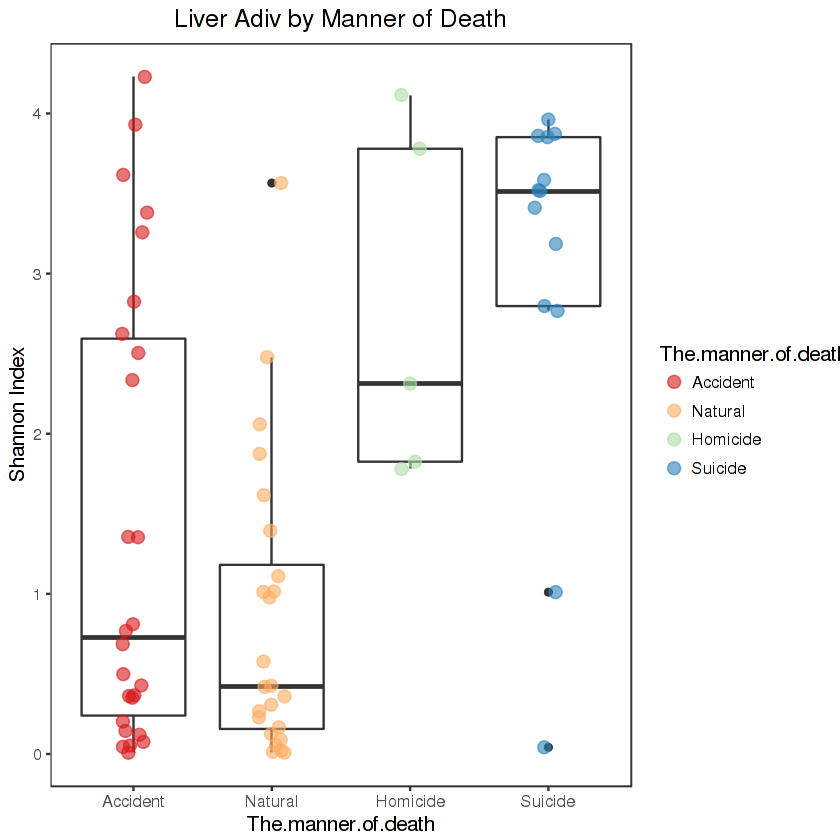

In [57]:
dfsha$The.manner.of.death <- factor(dfsha$The.manner.of.death, levels=c("Accident", "Natural","Homicide", "Suicide"))

p = ggplot(dfsha, aes(x = The.manner.of.death, y = Shannon)) + ggtitle("Liver Adiv by Manner of Death")

p = p + geom_boxplot() + ylab("Shannon Index")  #+ coord_flip(ylim = c(0,200))

#p = p + coord_cartesian(ylim = c(0, 2000))

#p = p + scale_y_continuous(limits = c(0,1200))

p = p + geom_point(size = 3,alpha=.6, aes(color = The.manner.of.death),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           plot.title = element_text(hjust = 0.5),
                           #legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

#p = p + facet_wrap(~The.manner.of.death)

p

In [59]:
krusk = kruskal.test(Shannon ~ The.manner.of.death, data=dfsha) 
krusk


	Kruskal-Wallis rank sum test

data:  Shannon by The.manner.of.death
Kruskal-Wallis chi-squared = 19.149, df = 3, p-value = 0.0002547


In [60]:
library(dunn.test)
dunn = dunn.test(dfsha$Shannon, g=dfsha$The.manner.of.death, method="bonferroni")
dunn

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 19.1492, df = 3, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |   Accident   Homicide    Natural
---------+---------------------------------
Homicide |  -1.950161
         |     0.1535
         |
 Natural |   1.231699   2.646419
         |     0.6542    0.0244*
         |
 Suicide |  -2.943251  -0.090187  -3.915656
         |    0.0097*     1.0000    0.0003*

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 19.14918

$Z
[1] -1.95016120  1.23169940  2.64641914 -2.94325194 -0.09018795 -3.91565650

$P
[1] 2.557845e-02 1.090307e-01 4.067448e-03 1.623920e-03 4.640689e-01
[6] 4.507927e-05

$P.adjusted
[1] 0.1534707259 0.6541841806 0.0244046854 0.0097435197 1.0000000000
[6] 0.0002704756

$comparisons
[1] "Accident - Homicide" "Accident - Natural"  "Homicide - Natural" 
[4] "Accident - Suicide"  "Homicide - Suicide"  "Natural - Suicide"

In [61]:
#Record Stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# export kruskal-wallis
cat("Shannon Div Krsukal-Wallis\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(krusk, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# add 2 newlines
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# export dunn.test
cat("Shannon Div Dunn Test\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(dunn, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

### Observed Diversity Calculations

In [8]:
obs = estimate_richness(cadaver_nt, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

In [9]:
#Export to local to remove "X"'s in front of SampleID, reimport and continue
#write.csv(obs, "/group/gilbert-lab/Lutz/Cadaver/temp_obs.csv")
obs = read.csv("/group/gilbert-lab/Lutz/Cadaver/temp_obs.csv")

In [10]:
dfobs = merge(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("The.manner.of.death") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("The.manner.of.death")

stats.obs = dfobs %>%
    group_by(The.manner.of.death) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(mean))
stats.obs

The.manner.of.death,median,mean,sd,sem
Natural,20.5,36.33333,35.68298,7.283759
Accident,33.0,56.26923,53.75467,10.542158
Homicide,80.0,87.60000,47.58991,21.282857
Suicide,115.0,99.38462,48.88343,13.557824


In [67]:
#Record Stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("Obs Richness stats\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(stats.obs, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)


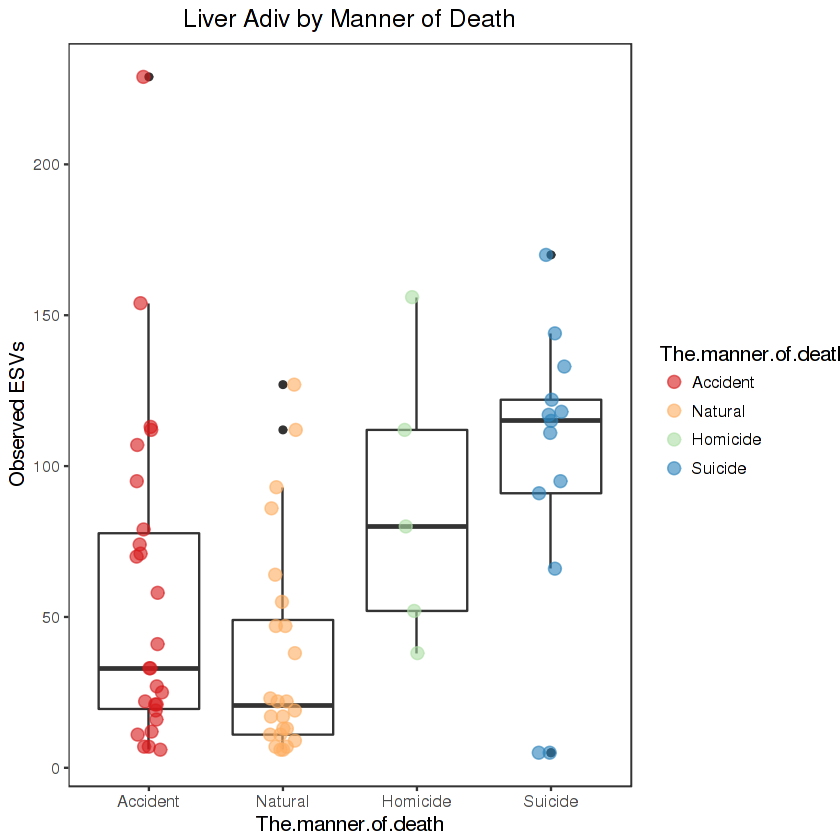

In [68]:
dfobs$The.manner.of.death <- factor(dfobs$The.manner.of.death, levels=c("Accident", "Natural","Homicide", "Suicide"))

p = ggplot(dfobs, aes(x = The.manner.of.death, y = Observed)) + ggtitle("Liver Adiv by Manner of Death")

p = p + geom_boxplot() + ylab("Observed ESVs")  #+ coord_flip(ylim = c(0,200))

#p = p + coord_cartesian(ylim = c(0, 2000))

#p = p + scale_y_continuous(limits = c(0,1200))

p = p + geom_point(size = 3,alpha=.6, aes(color = The.manner.of.death),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           plot.title = element_text(hjust = 0.5),
                           #legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

#p = p + facet_wrap(~The.manner.of.death)

p

In [70]:
krusk = kruskal.test(Observed ~ The.manner.of.death, data=dfobs) 
krusk


	Kruskal-Wallis rank sum test

data:  Observed by The.manner.of.death
Kruskal-Wallis chi-squared = 13.253, df = 3, p-value = 0.004121


In [71]:
library(dunn.test)
dunn = dunn.test(dfobs$Observed, g=dfobs$The.manner.of.death, method="bonferroni")
dunn

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 13.2526, df = 3, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |   Accident   Homicide    Natural
---------+---------------------------------
Homicide |  -1.453546
         |     0.4382
         |
 Natural |   1.351255   2.221951
         |     0.5298     0.0789
         |
 Suicide |  -2.233953  -0.093176  -3.314282
         |     0.0765     1.0000    0.0028*

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 13.25263

$Z
[1] -1.45354686  1.35125517  2.22195121 -2.23395301 -0.09317606 -3.31428258

$P
[1] 0.073035989 0.088306854 0.013143302 0.012743083 0.462881846 0.000459393

$P.adjusted
[1] 0.438215934 0.529841126 0.078859809 0.076458496 1.000000000 0.002756358

$comparisons
[1] "Accident - Homicide" "Accident - Natural"  "Homicide - Natural" 
[4] "Accident - Suicide"  "Homicide - Suicide"  "Natural - Suicide"

In [72]:
#Record Stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# export kruskal-wallis
cat("Observed Richness Krsukal-Wallis\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(krusk, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# add 2 newlines
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# export dunn.test
cat("Observed Richness Dunn Test\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(dunn, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

SampleID,Observed,BarcodeSequence,LinkerPrimerSequence,RTL_run,Case_no,Sex,Age,Ethnicity,Order,...,Organ,RTLID,Samplename,Cause.of.death,The.manner.of.death,Height.cm,Weight.kg,bmi,bmi_category,Description
3813.13,112,AAAACACA,GTGCCAGCMGCCGCGGTAA,3813,C15,F,40,C,3813,...,Liver,13,13-MS515F,Bowel Obstruction,Natural,165,55,20.20,normal,3813.13
3813.16,33,AAAACACT,GTGCCAGCMGCCGCGGTAA,3813,C18,F,28,L,3813,...,Liver,16,16-MS515F,Car Accident,Accident,162,73,27.82,overweight,3813.16
3813.2,22,AAAACAGT,GTGCCAGCMGCCGCGGTAA,3813,C25,F,48,C,3813,...,Liver,2,2-MS515F,Coronary Heart Disease,Natural,162,70,26.67,overweight,3813.2
3813.26,6,AAAACCAG,GTGCCAGCMGCCGCGGTAA,3813,C29,M,48,C,3813,...,Liver,26,26-MS515F,Overdose,Accident,183,83,24.78,normal,3813.26
3813.3,47,AAAACCCG,GTGCCAGCMGCCGCGGTAA,3813,C1,M,51,C,3813,...,Liver,3,3-MS515F,Coronary Heart Disease,Natural,180,82,25.31,overweight,3813.3
3813.31,52,AAAACCGA,GTGCCAGCMGCCGCGGTAA,3813,C32,M,45,A,3813,...,Liver,31,31-MS515F,Gunshot wound,Homicide,178,117,36.93,obese,3813.31


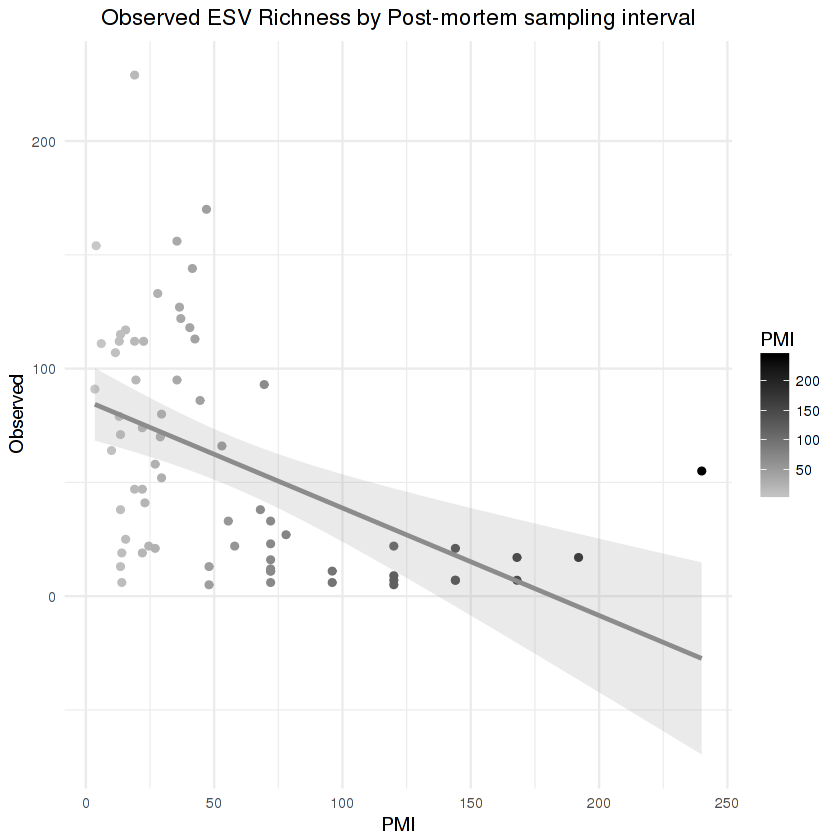

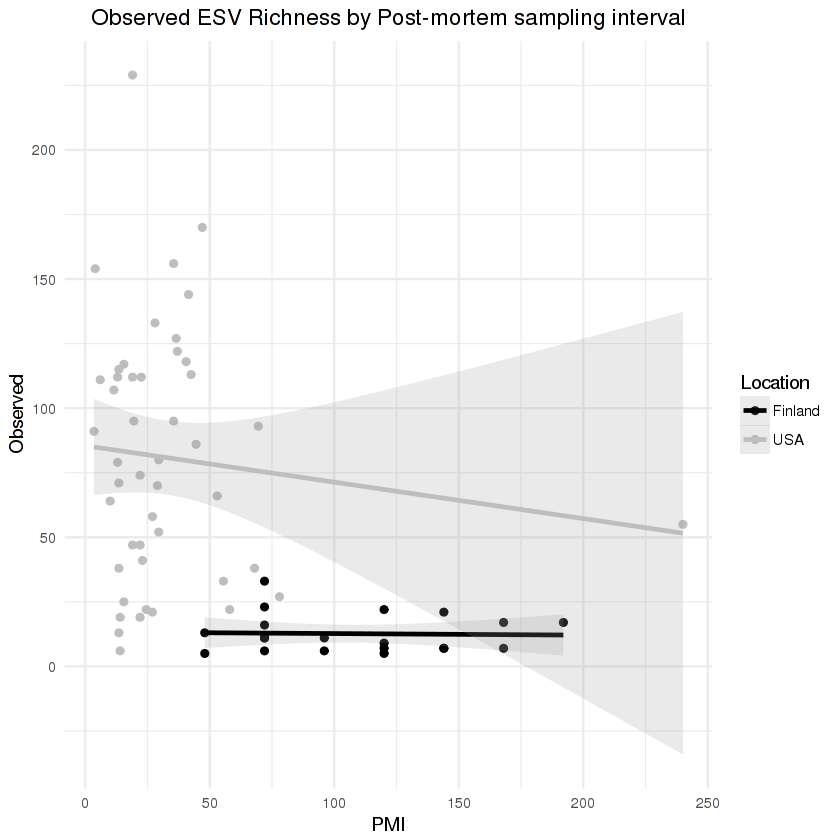

In [11]:
p1 = ggplot(dfobs, aes(x=PMI, y=Observed, colour = PMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p1 = p1 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p1 = p1 + scale_colour_gradient(low = "grey78", high = "black")
p1

p2 = ggplot(dfobs, aes(x=PMI, y=Observed, colour = Location)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval")
p2 = p2 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p2 = p2 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p2 = p2 + scale_colour_manual(values = c("Black", "Gray"))
p2

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

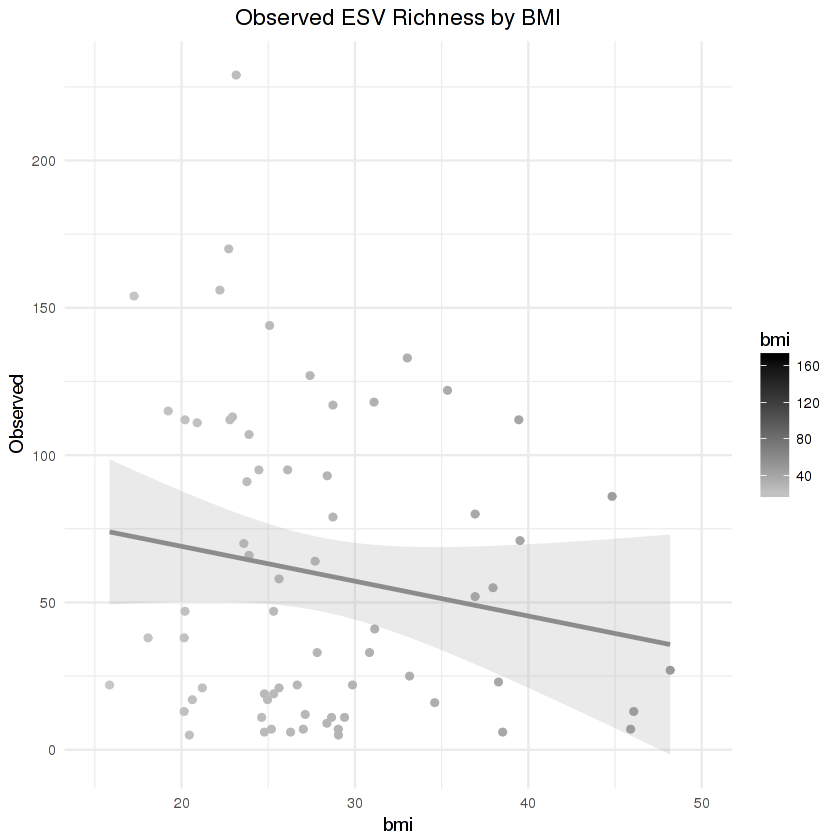

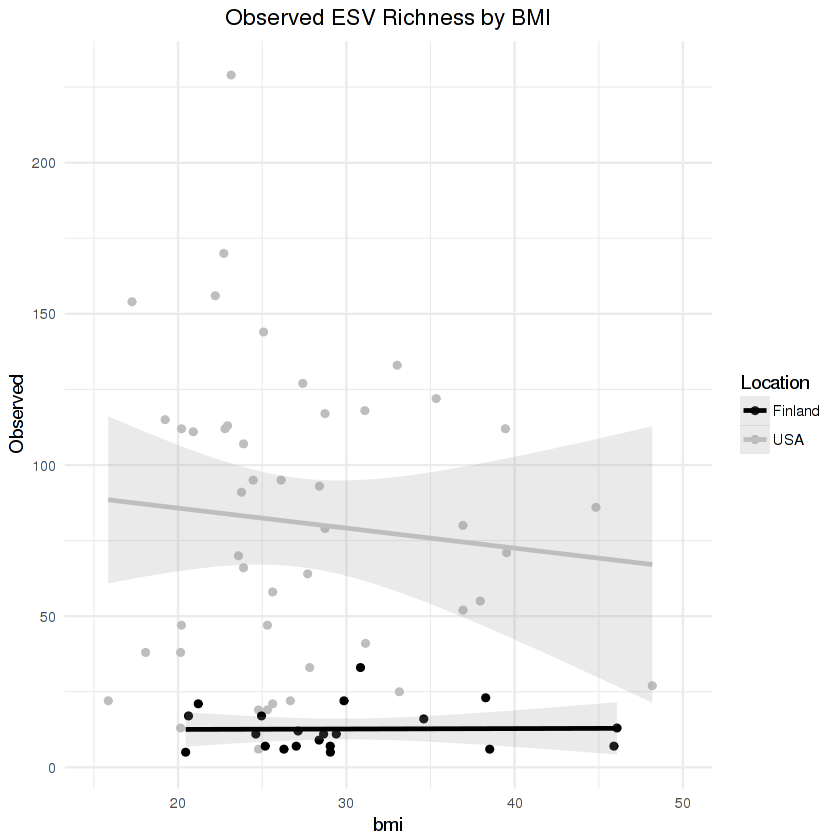

In [86]:
p3 = ggplot(dfobs, aes(x=bmi, y=Observed, colour = bmi)) + geom_point() + 
        ggtitle("Observed ESV Richness by BMI")
p3 = p3 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55")
     + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
     + scale_colour_gradient(low = "grey78", high = "black")
     + xlim(c(15,50))
p3

p4 = ggplot(dfobs, aes(x=bmi, y=Observed, colour = Location)) + geom_point() + 
        ggtitle("Observed ESV Richness by BMI")
p4 = p4 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p4 = p4 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p4 = p4 + scale_colour_manual(values = c("Black", "Gray"))
p4 = p4 + xlim(c(15,50))
p4

In [87]:
#SUMMARIZE REGRESSION COEFFICIENTS - Break down by sample type before running
fit <- lm(bmi ~ Observed, data = dfobs)
summary(fit)


Call:
lm(formula = bmi ~ Observed, data = dfobs)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.712  -6.124  -3.805   1.015 141.135 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 30.81899    3.53328   8.722 1.36e-12 ***
Observed    -0.01168    0.04496  -0.260    0.796    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.92 on 66 degrees of freedom
Multiple R-squared:  0.001022,	Adjusted R-squared:  -0.01411 
F-statistic: 0.06751 on 1 and 66 DF,  p-value: 0.7958


In [81]:
# Record stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("Observed Richness by PMI_hr Regression\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(summary(fit), file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

In [13]:
dfobs.usa = dfobs[which(dfobs$Location=='USA'),]
dfobs.fin = dfobs[which(dfobs$Location=='Finland'),]

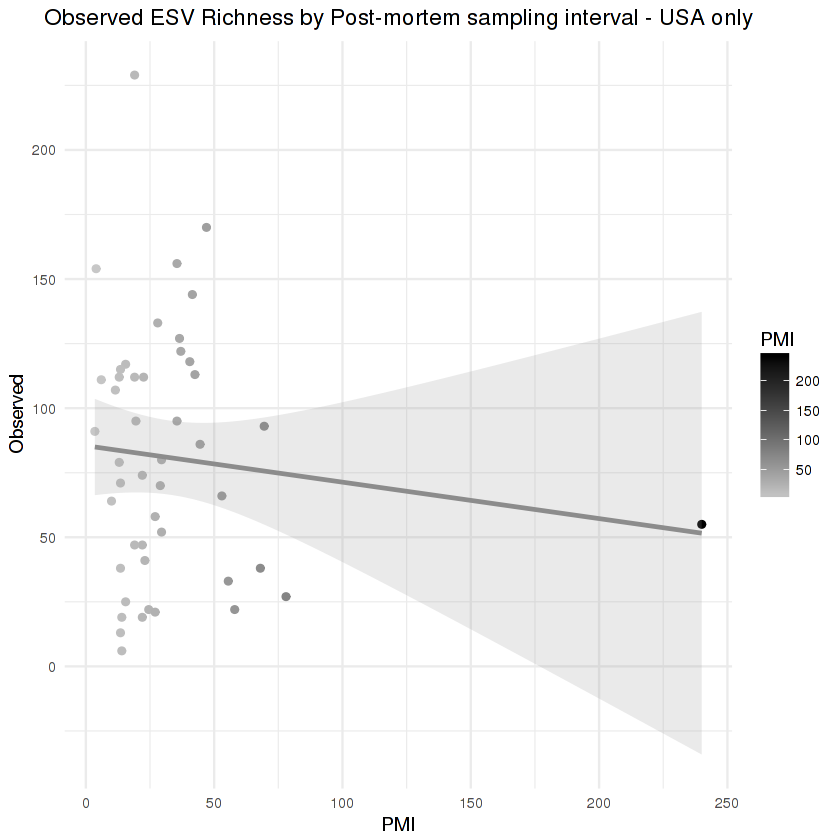

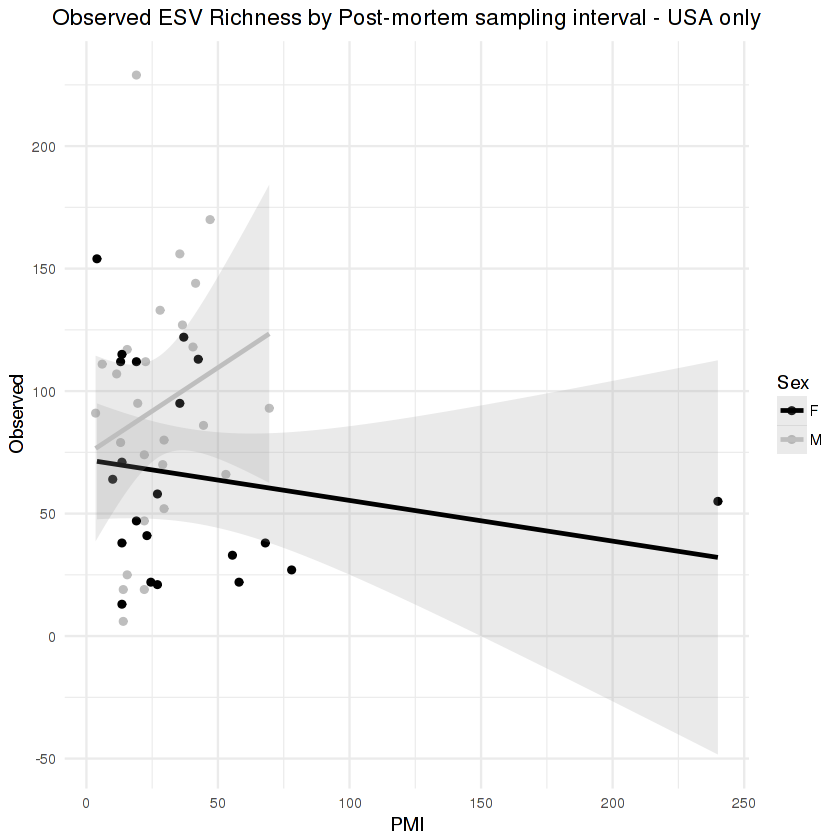

In [15]:
p5 = ggplot(dfobs.usa, aes(x=PMI, y=Observed, colour = PMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - USA only")
p5 = p5 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p5 = p5 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p5 = p5 + scale_colour_gradient(low = "grey78", high = "black")
p5

p6 = ggplot(dfobs.usa, aes(x=PMI, y=Observed, colour = Sex)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - USA only")
p6 = p6 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p6 = p6 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p6 = p6 + scale_colour_manual(values = c("Black", "Gray"))
p6

In [20]:
fit <- lm(PMI ~ Observed, data = dfobs.usa)
summary(fit)


Call:
lm(formula = PMI ~ Observed, data = dfobs.usa)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.475 -18.325 -10.272   9.506 205.301 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 38.86136   10.20981   3.806 0.000424 ***
Observed    -0.07567    0.10858  -0.697 0.489413    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 35.77 on 45 degrees of freedom
Multiple R-squared:  0.01068,	Adjusted R-squared:  -0.01131 
F-statistic: 0.4858 on 1 and 45 DF,  p-value: 0.4894


In [21]:
# Record stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("USA only - Observed Richness by PMI_hr Regression\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(summary(fit), file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

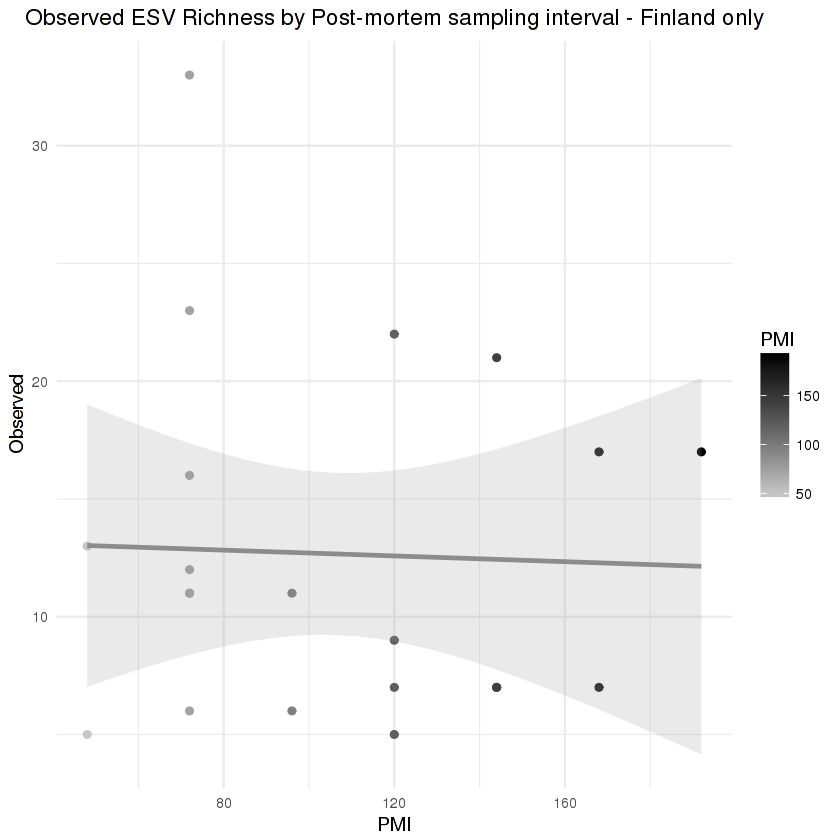

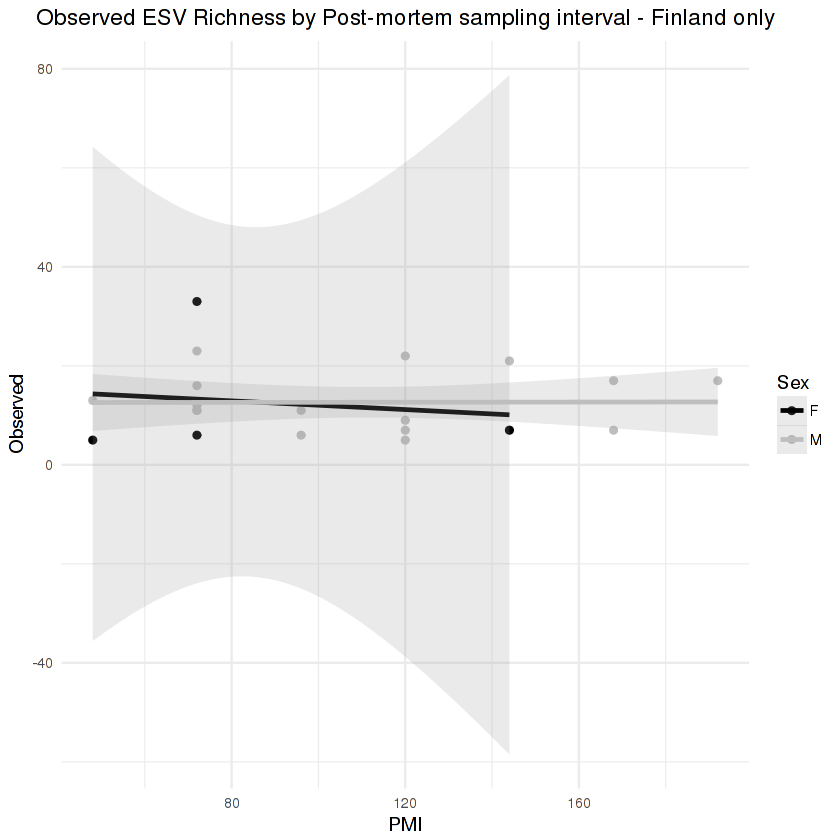

In [16]:
p7 = ggplot(dfobs.fin, aes(x=PMI, y=Observed, colour = PMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - Finland only")
p7 = p7 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p7 = p7 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p7 = p7 + scale_colour_gradient(low = "grey78", high = "black")
p7

p8 = ggplot(dfobs.fin, aes(x=PMI, y=Observed, colour = Sex)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - Finland only")
p8 = p8 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p8 = p8 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p8 = p8 + scale_colour_manual(values = c("Black", "Gray"))
p8

In [22]:
fit <- lm(PMI ~ Observed, data = dfobs.fin)
summary(fit)


Call:
lm(formula = PMI ~ Observed, data = dfobs.fin)

Residuals:
   Min     1Q Median     3Q    Max 
-59.81 -34.42 -10.62  36.58  86.58 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 108.8128    19.0398   5.715 1.65e-05 ***
Observed     -0.1995     1.3077  -0.153     0.88    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 43.03 on 19 degrees of freedom
Multiple R-squared:  0.001224,	Adjusted R-squared:  -0.05134 
F-statistic: 0.02328 on 1 and 19 DF,  p-value: 0.8803


In [23]:
# Record stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("Finland only - Observed Richness by PMI_hr Regression\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(summary(fit), file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

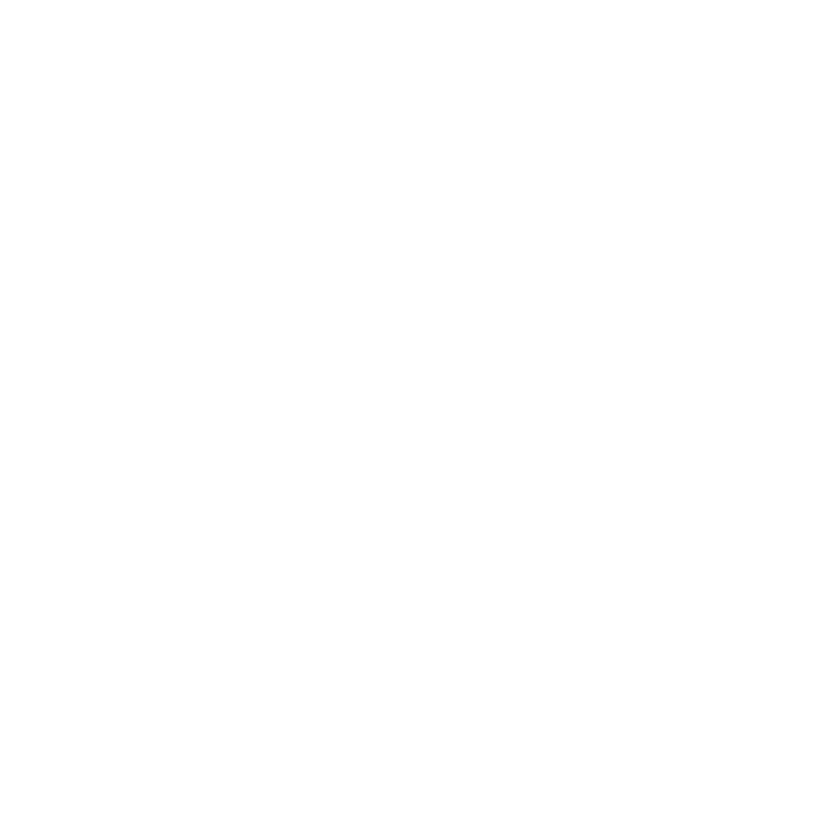

In [24]:
p9 = ggplot(dfobs.usa, aes(x=BMI, y=Observed, colour = BMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by BMI - USA only")
p9 = p9 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p9 = p9 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p9 = p9 + scale_colour_gradient(low = "grey78", high = "black")
p9

p10 = ggplot(dfobs.usa, aes(x=BMI, y=Observed, colour = Sex)) + geom_point() + 
        ggtitle("Observed ESV Richness by BMI - USA only")
p10 = p10 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p10 = p10 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p10 = p10 + scale_colour_manual(values = c("Black", "Gray"))
p10

### Betadiversity

In [88]:
cadaver.df = data.frame(sample_data(cadaver))

In [90]:
# WEIGHTED UNIFRAC
cadaver.dist.wunif = distance(cadaver, method = "wunifrac", type = "samples")
cadaver.wunif.adtest = adonis2(cadaver.dist.wunif ~ Sex + Age + Ethnicity + The.manner.of.death + PMI + bmi, strata = Locality, by = "margin", data=cadaver.df)
cadaver.wunif.adtest

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGGAGGGGGCTAGCGTTATTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCCGGAGCTCAACTCCGGAACTGCCTTTAAGACTGCATCGCTTGAATCCGGGAGAGGTGAGTGGAATTCCGAG -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.18464028,0.02564665,2.0327953,0.049
Age,1,0.18039278,0.02505667,1.9860325,0.061
Ethnicity,2,0.17622320,0.02447751,0.9700637,0.458
The.manner.of.death,3,0.51340859,0.07131278,1.8841222,0.014
PMI,1,0.23824966,0.03309303,2.6230072,0.017
bmi,1,0.08480829,0.01177992,0.9336960,0.514
Residual,58,5.26818237,0.73175386,NA,NA
Total,67,7.19939130,1.00000000,NA,NA


In [91]:
# UNWEIGHTED UNIFRAC
cadaver.dist.unif = distance(cadaver, method = "unifrac", type = "samples")
cadaver.unif.adtest = adonis2(cadaver.dist.unif ~ Sex + Age + Ethnicity + The.manner.of.death + PMI + bmi, strata = Locality, by = "margin", data=cadaver.df)
cadaver.unif.adtest

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGGGGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGCGCGTAGGCGGGACGTCAAGTCAGCGGTAAAAGACTGCAGCTAAACTGTAGCACGCCGTTGAAACTGGCGCCCTGGAGACGAGACGAGGGAGGCGGAACAAGTGAA -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.2245641,0.01311843,1.0387621,0.334
Age,1,0.4113528,0.02403012,1.9027869,0.039
Ethnicity,2,0.5085661,0.02970907,1.1762324,0.213
The.manner.of.death,3,0.8682916,0.05072326,1.3388134,0.123
PMI,1,1.0829688,0.06326412,5.0094684,0.001
bmi,1,0.2082932,0.01216793,0.9634981,0.488
Residual,58,12.5386941,0.73247676,NA,NA
Total,67,17.1182142,1.00000000,NA,NA


In [92]:
# BRAY-CURTIS
cadaver.dist.bc = distance(cadaver, method = "bray", type = "samples")
cadaver.bc.adtest = adonis2(cadaver.dist.bc ~ Sex + Age + Ethnicity + The.manner.of.death + PMI + bmi, strata = Locality, by = "margin", data=cadaver.df)
cadaver.bc.adtest

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.6786432,0.02242474,1.6009085,0.063
Age,1,0.5526084,0.01826011,1.3035944,0.153
Ethnicity,2,0.8010969,0.02647103,0.9448873,0.559
The.manner.of.death,3,1.7562704,0.05803329,1.3810045,0.024
PMI,1,0.5725741,0.01891984,1.3506931,0.123
bmi,1,0.4365889,0.01442642,1.0299063,0.431
Residual,58,24.5868562,0.81243543,NA,NA
Total,67,30.2631512,1.00000000,NA,NA


In [93]:
# Record stats
# Wunif adonis2 stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.wunif.adtest - with MoD\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.wunif.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# Unif adonis2 stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.unif.adtest - with MoD\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.unif.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
#Bray-Curtis adonis2 stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.bc.adtest - with MoD\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.bc.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

In [94]:
cadaver.wunif.log = ordinate(cadaver, method = "PCoA", distance = "wunifrac")
cadaver.wunif.evals = cadaver.wunif.log$values$Eigenvalues

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGAAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGAAGTGAAAGCCCCGGGCTCAACCTGGGAATTGCTTTCAAAACTGACAGGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTG -- in the phylogenetic tree in the data you provided.”

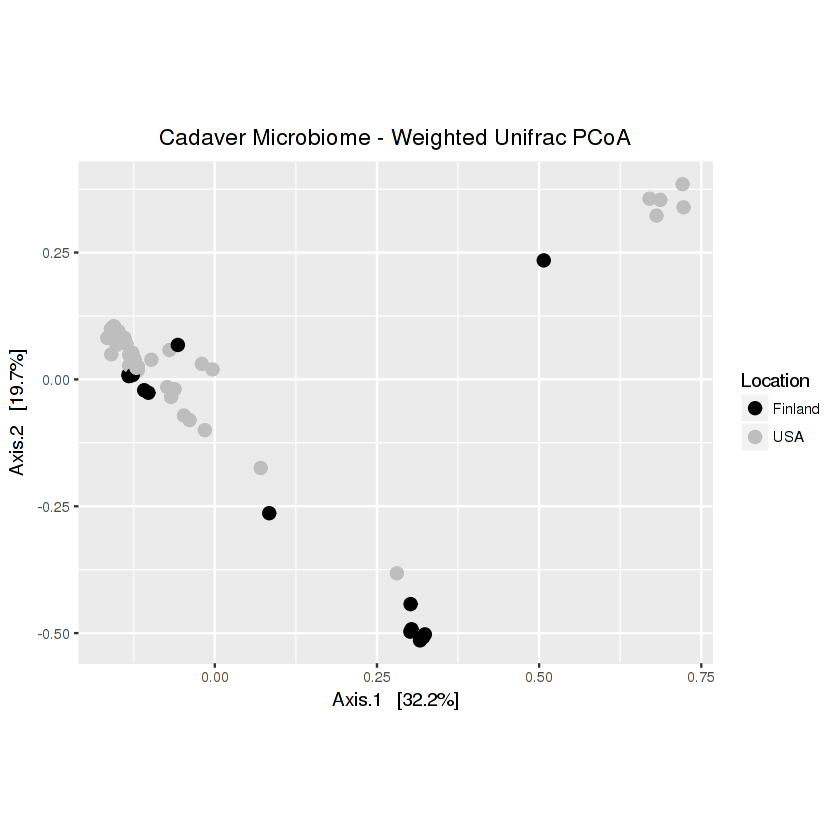

In [95]:
p = plot_ordination(cadaver, cadaver.wunif.log, color = "Location") + 
    ggtitle("Cadaver Microbiome - Weighted Unifrac PCoA") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.wunif.evals[2] / cadaver.wunif.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
p = p + scale_colour_manual(values = c("Black", "Gray"))
#p = p + scale_colour_brewer(palette="Spectral")
p                            

In [96]:
cadaver.unif.log = ordinate(cadaver, method = "PCoA", distance = "unifrac")
cadaver.unif.evals = cadaver.unif.log$values$Eigenvalues

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTATGTCACAAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCGGGGCTCAACTCTGTATTGCGTTGGAAACTGCATGACTAGAGTACTGGAGAGGTAAGCGGAACTACAAGT -- in the phylogenetic tree in the data you provided.”

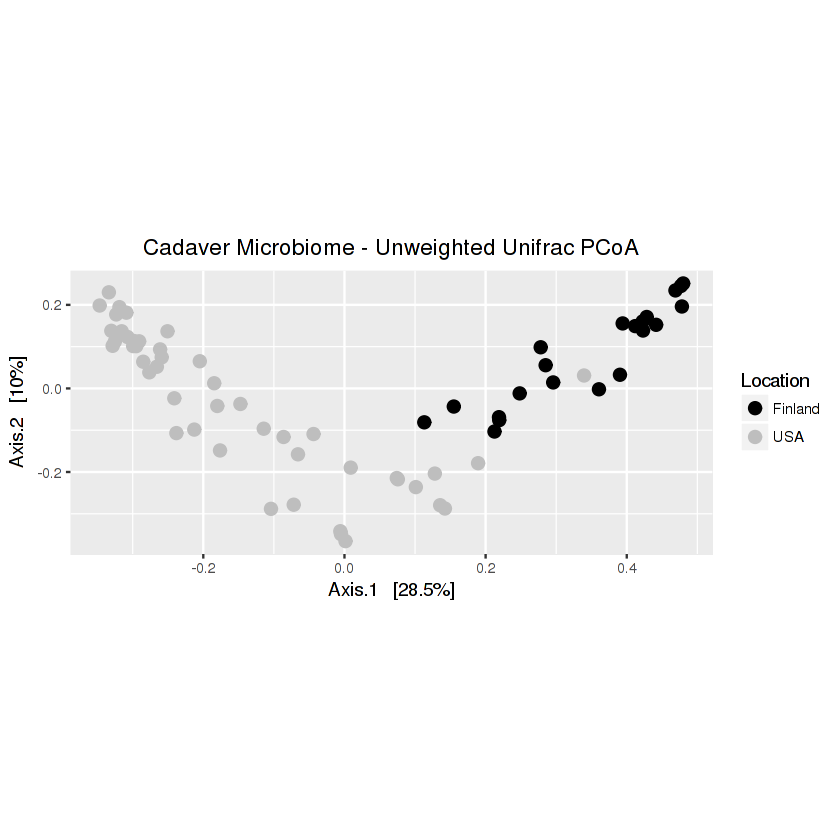

In [97]:
p = plot_ordination(cadaver, cadaver.unif.log, color = "Location") + 
    ggtitle("Cadaver Microbiome - Unweighted Unifrac PCoA") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.unif.evals[2] / cadaver.unif.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
p = p + scale_colour_manual(values = c("Black", "Gray"))
#p = p + scale_colour_brewer(palette="Spectral")
p    

In [98]:
cadaver.bc.log = ordinate(cadaver, method = "PCoA", distance = "bray")
cadaver.bc.evals = cadaver.bc.log$values$Eigenvalues

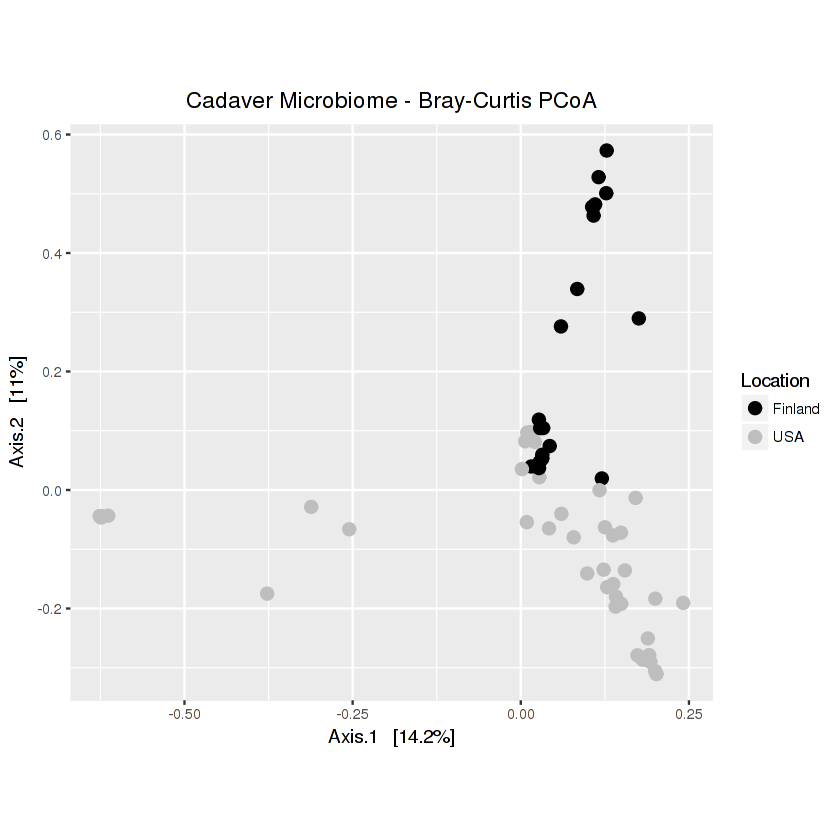

In [99]:
p = plot_ordination(cadaver, cadaver.bc.log, color = "Location") + 
    ggtitle("Cadaver Microbiome - Bray-Curtis PCoA") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.bc.evals[2] / cadaver.bc.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
p = p + scale_colour_manual(values = c("Black", "Gray"))
#p = p + scale_colour_brewer(palette="Spectral")
p    

#### Betadispersion

In [100]:
#Weighted Unifrac

beta.disp.cadaver.wuf = betadisper(cadaver.dist.wunif,group = sample_data(cadaver)$The.manner.of.death)
beta.disp.cadaver.wuf = beta.disp.cadaver.wuf$distances
beta.disp.cadaver.wuf = data.frame(d = beta.disp.cadaver.wuf, SampleID = names(beta.disp.cadaver.wuf))
beta.disp.cadaver.wuf2 = left_join(beta.disp.cadaver.wuf, sample_tab, by="SampleID")

Warning message:
“Column `SampleID` joining factors with different levels, coercing to character vector”

In [101]:
cadaver.wunif_summary = summary(beta.disp.cadaver.wuf2$d)
cadaver.wunif_summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1384  0.2365  0.3015  0.2972  0.3424  0.5310 

In [102]:
#Sort by ascending mean
avg_obs <- aggregate(d ~ The.manner.of.death, data = beta.disp.cadaver.wuf2, mean)
beta.disp.cadaver.wuf2$Manner_of_death <-factor(beta.disp.cadaver.wuf2$The.manner.of.death, levels=avg_obs[order(avg_obs$d), "The.manner.of.death"])

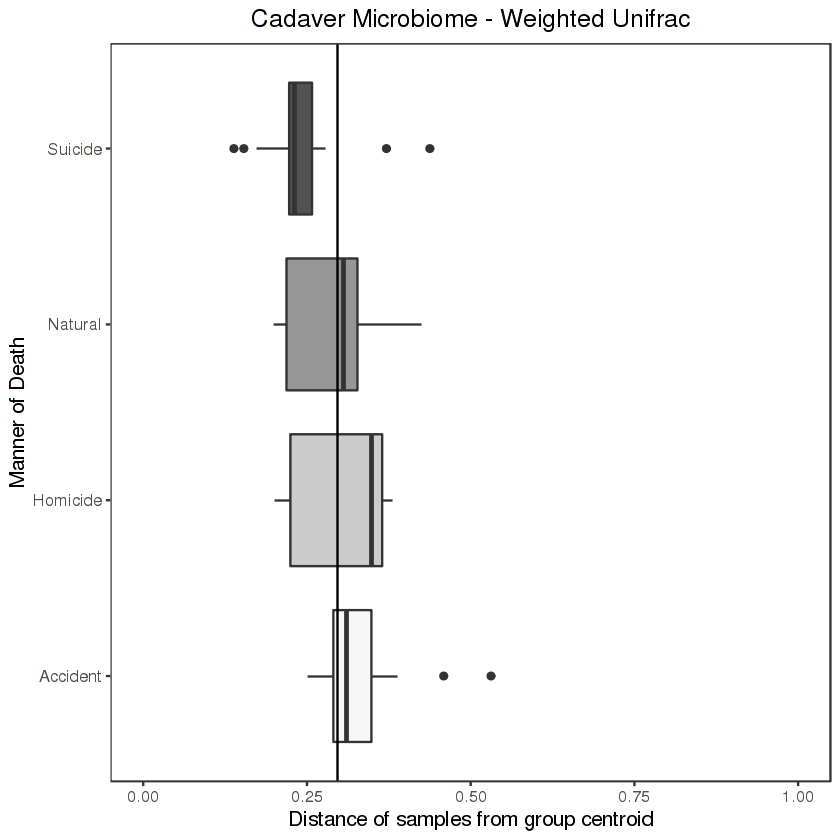

In [103]:
p = ggplot(beta.disp.cadaver.wuf2, aes(x = as.factor(The.manner.of.death), y = d, fill = as.factor(The.manner.of.death))) + ggtitle("Cadaver Microbiome - Weighted Unifrac")

p = p + geom_boxplot() + 
        ylab("Distance of samples from group centroid") + 
        xlab("Manner of Death") + 
        coord_flip(ylim = c(0,1))

p = p + scale_fill_brewer(palette="Greys")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           plot.title = element_text(hjust = 0.5),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#Mean taken from "cadaver.wunif_summary"
p = p + geom_hline(yintercept = 0.2972)

p

In [104]:
#Unweighted Unifrac

beta.disp.cadaver.uf = betadisper(cadaver.dist.unif,group = sample_data(cadaver)$The.manner.of.death)
beta.disp.cadaver.uf = beta.disp.cadaver.uf$distances
beta.disp.cadaver.uf = data.frame(d = beta.disp.cadaver.uf, SampleID = names(beta.disp.cadaver.uf))
beta.disp.cadaver.uf2 = left_join(beta.disp.cadaver.uf, sample_tab, by="SampleID")

cadaver.unif_summary = summary(beta.disp.cadaver.uf2$d)
cadaver.unif_summary

Warning message:
“Column `SampleID` joining factors with different levels, coercing to character vector”

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3069  0.4263  0.4606  0.4709  0.5033  0.7553 

In [105]:
#Sort by ascending mean
avg_obs <- aggregate(d ~ The.manner.of.death, data = beta.disp.cadaver.uf2, mean)
beta.disp.cadaver.uf2$The.manner.of.death <-factor(beta.disp.cadaver.uf2$The.manner.of.death, levels=avg_obs[order(avg_obs$d), "The.manner.of.death"])

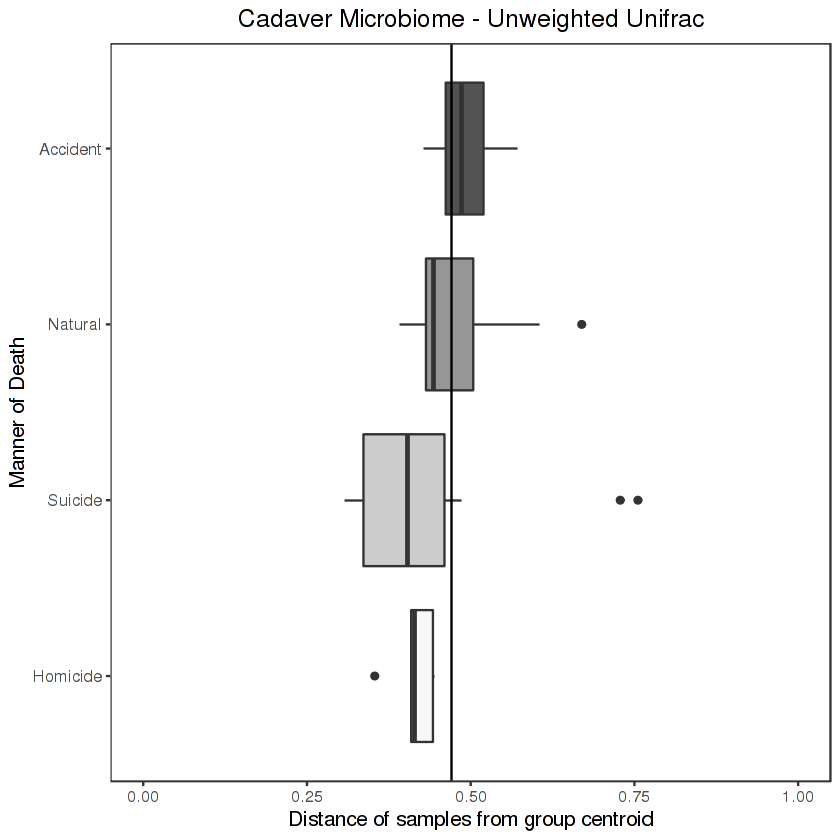

In [106]:
p = ggplot(beta.disp.cadaver.uf2, aes(x = as.factor(The.manner.of.death), y = d, fill = as.factor(The.manner.of.death))) + ggtitle("Cadaver Microbiome - Unweighted Unifrac")

p = p + geom_boxplot() + 
        ylab("Distance of samples from group centroid") + 
        xlab("Manner of Death") + 
        coord_flip(ylim = c(0,1))

p = p + scale_fill_brewer(palette="Greys")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           plot.title = element_text(hjust = 0.5),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#Mean taken from "cadaver.unif_summary"
p = p + geom_hline(yintercept = 0.4709)

p

In [107]:
#Bray-Curtis

beta.disp.cadaver.bc = betadisper(cadaver.dist.bc,group = sample_data(cadaver)$The.manner.of.death)
beta.disp.cadaver.bc = beta.disp.cadaver.bc$distances
beta.disp.cadaver.bc = data.frame(d = beta.disp.cadaver.bc, SampleID = names(beta.disp.cadaver.bc))
beta.disp.cadaver.bc2 = left_join(beta.disp.cadaver.bc, sample_tab, by="SampleID")

cadaver.bc_summary = summary(beta.disp.cadaver.bc2$d)
cadaver.bc_summary

Warning message:
“Column `SampleID` joining factors with different levels, coercing to character vector”

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4912  0.5995  0.6500  0.6381  0.6860  0.7633 

In [109]:
#Sort by ascending mean
avg_obs <- aggregate(d ~ The.manner.of.death, data = beta.disp.cadaver.bc2, mean)
beta.disp.cadaver.bc2$The.manner.of.death <-factor(beta.disp.cadaver.bc2$The.manner.of.death, levels=avg_obs[order(avg_obs$d), "The.manner.of.death"])

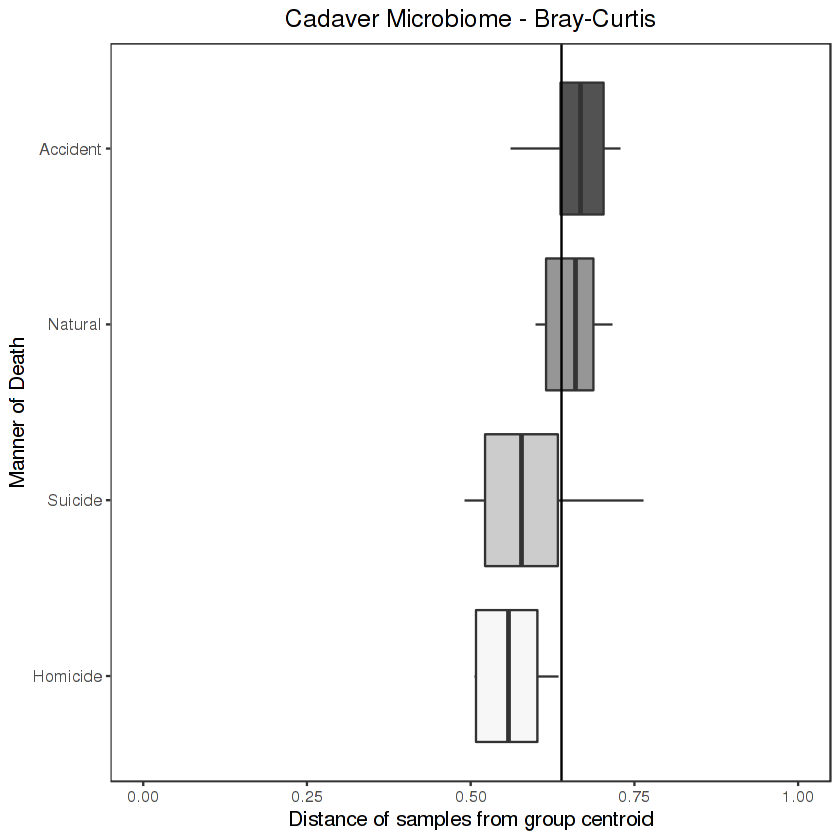

In [111]:
p = ggplot(beta.disp.cadaver.bc2, aes(x = as.factor(The.manner.of.death), y = d, fill = as.factor(The.manner.of.death))) + ggtitle("Cadaver Microbiome - Bray-Curtis")

p = p + geom_boxplot() + 
        ylab("Distance of samples from group centroid") + 
        xlab("Manner of Death") + 
        coord_flip(ylim = c(0,1))

p = p + scale_fill_brewer(palette="Greys")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           plot.title = element_text(hjust = 0.5),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#Mean taken from "cadaver.unif_summary"
p = p + geom_hline(yintercept = 0.6381)

p

### Rank Abundance

In [5]:
cadaver.mdf = psmelt(cadaver)

In [6]:
write.csv(cadaver.mdf, "/group/gilbert-lab/Lutz/Cadaver/phyloseq_files_30June2018/cadaver.mdf.csv")

In [43]:
colnames(cadaver.mdf)

[1] "X"                    "OTU"                  "Sample"              
 [4] "Abundance"            "X.SampleID"           "BarcodeSequence"     
 [7] "LinkerPrimerSequence" "RTL_run"              "Case_no"             
[10] "Sex"                  "Age"                  "Ethnicity"           
[13] "Order"                "Location"             "PMI"                 
[16] "Organ"                "RTLID"                "Samplename"          
[19] "Cause.of.death"       "The.manner.of.death"  "Height.cm"           
[22] "Weight.kg"            "bmi"                  "bmi_category"        
[25] "Description"          "Rank1"                "Rank2"               
[28] "Rank3"                "Rank4"                "Rank5"               
[31] "Rank6"                "Rank7"                "TaxID"

In [25]:
#New column "TaxID" to identify highest level of taxonomic identification
cadaver.mdf = read.csv("/group/gilbert-lab/Lutz/Cadaver/phyloseq_files_30June2018/cadaver.mdf.csv")


In [26]:
#Subset by Locality

cadaver.usa.mdf = cadaver.mdf[which(cadaver.mdf$Location=='USA'),]
cadaver.fin.mdf = cadaver.mdf[which(cadaver.mdf$Location=='Finland'),]

In [27]:
colnames(cadaver.fin.mdf)

[1] "X"                    "OTU"                  "Sample"              
 [4] "Abundance"            "X.SampleID"           "BarcodeSequence"     
 [7] "LinkerPrimerSequence" "RTL_run"              "Case_no"             
[10] "Sex"                  "Age"                  "Ethnicity"           
[13] "Order"                "Location"             "PMI"                 
[16] "PMI_days"             "Organ"                "RTLID"               
[19] "Samplename"           "Cause.of.death"       "The.manner.of.death" 
[22] "Height.cm"            "Weight.kg"            "bmi"                 
[25] "bmi_category"         "Description"          "Rank1"               
[28] "Rank2"                "Rank3"                "Rank4"               
[31] "Rank5"                "Rank6"                "Rank7"               
[34] "TaxID"

#### Plot top taxa

In [34]:
N = 15

topN = cadaver.usa.mdf %>%
    group_by(TaxID) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(TaxID) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("TaxID")

mdf.other = cadaver.usa.mdf %>%
    mutate(TaxID.other = ifelse(TaxID %in% topN, as.character(TaxID), "Other")) %>%
    group_by(Sample, TaxID.other, PMI_days) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(TaxID.other, PMI_days) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((TaxID.other))

Selecting by m


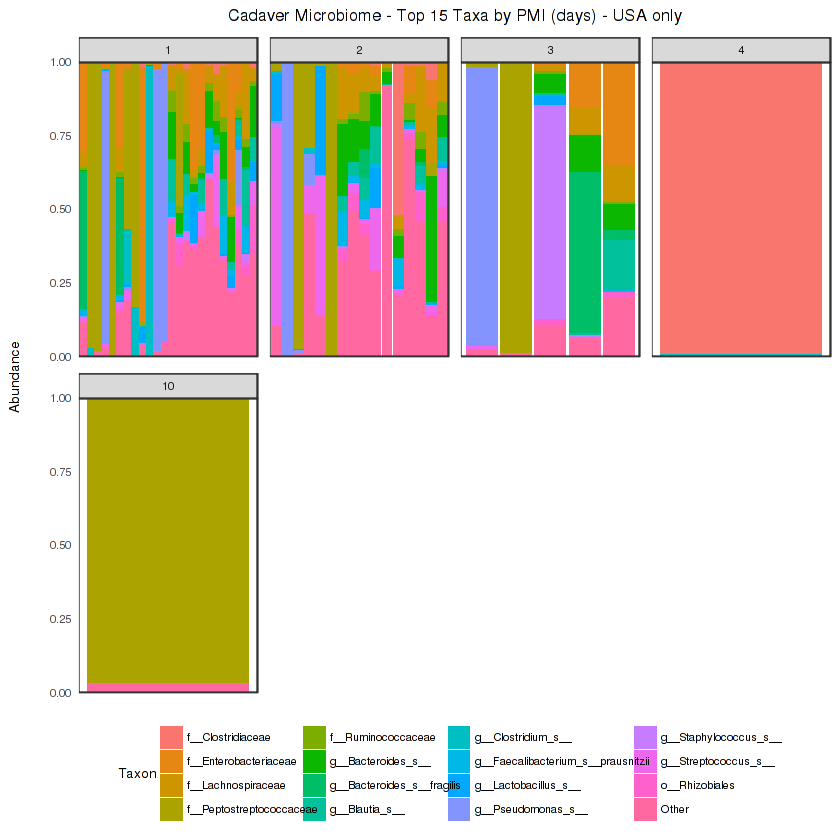

In [35]:
#mdf.other$Location <- factor(mdf.other$Location)

p = ggplot(mdf.other, aes(x=Sample, y = Abundance, fill = TaxID.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) #+ 
    #scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Taxon", ncol = 5, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=8, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              legend.key.size = unit(1, "mm"),
              legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              legend.key.width = unit(0.5, "mm"),
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))
               
p = p + ggtitle("Cadaver Microbiome - Top 15 Taxa by PMI (days) - USA only")

p = p + facet_wrap(~PMI_days, scales = "free_x", ncol = 4)

#p = p + facet_grid(The.manner.of.death ~ Sex, scales = "free_x")

p

#### Plot top 10 most abundant families

In [33]:
N = 10

topN = cadaver.mdf %>%
    group_by(Rank6_7) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank6_7) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank6_7")

mdf.other = cadaver.mdf %>%
    mutate(Rank6_7.other = ifelse(Rank6_7 %in% topN, as.character(Rank6_7), "Other")) %>%
    group_by(Sample, Rank6_7.other, Location, bmi_category) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(Rank6_7.other, Location, bmi_category) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank6_7.other))

Selecting by m


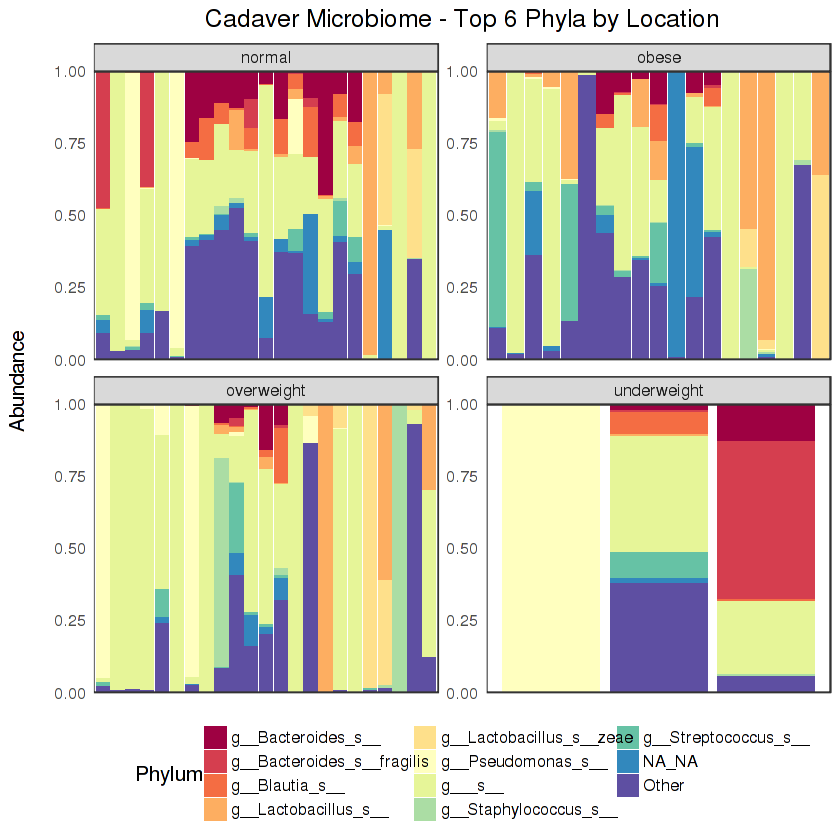

In [41]:
mdf.other$Location <- factor(mdf.other$Location)

p = ggplot(mdf.other, aes(x=factor(Sample), y = Abundance, fill = Rank6_7.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Phylum", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=12, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              legend.key.size = unit(1, "mm"),
              legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Cadaver Microbiome - Top 6 Phyla by Location")

p = p + facet_wrap(~bmi_category, shrink = TRUE, scales = "free")

p

#### Top 10 Orders by Manner of Death

In [143]:
N = 10

topN = cadaver.mdf %>%
    group_by(Rank4) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank4) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank4")

mdf.other = cadaver.mdf %>%
    mutate(Rank4.other = ifelse(Rank4 %in% topN, as.character(Rank4), "Other")) %>%
    group_by(Sample, Rank4.other, The.manner.of.death) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(Rank4.other, The.manner.of.death) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank4.other))

Selecting by m


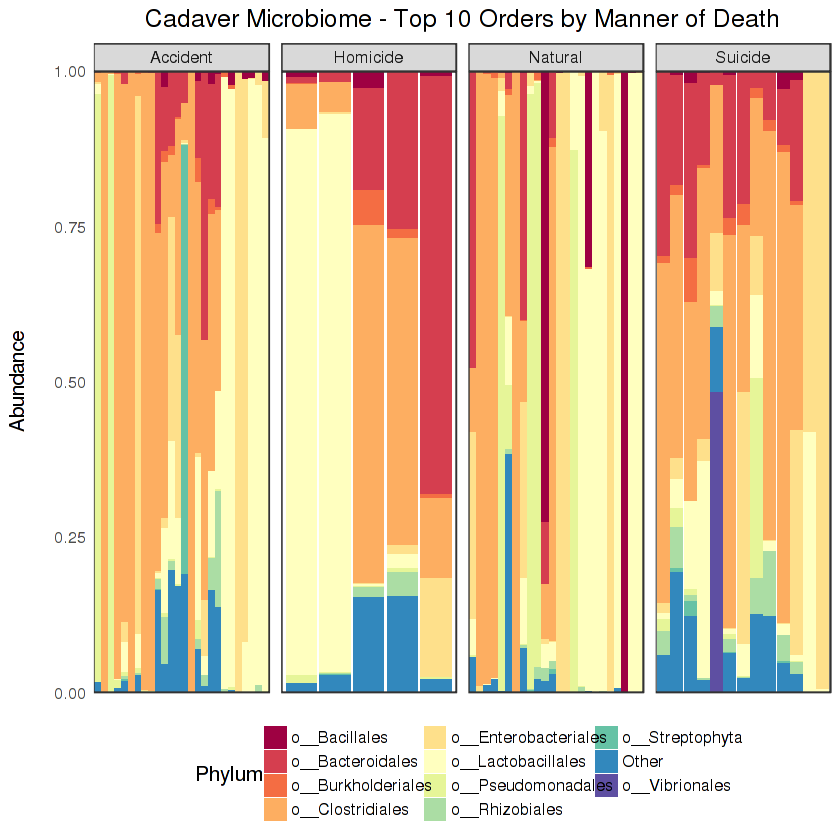

In [145]:
mdf.other$The.manner.of.death <- factor(mdf.other$The.manner.of.death)

p = ggplot(mdf.other, aes(x=Sample, y = Abundance, fill = Rank4.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Phylum", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=12, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              legend.key.size = unit(1, "mm"),
              legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Cadaver Microbiome - Top 10 Orders by Manner of Death")

p = p + facet_wrap(~The.manner.of.death, shrink = TRUE, scales = "free_x", ncol=4)

p

#### Top 10 Orders by Location

In [146]:
N = 10

topN = cadaver.mdf %>%
    group_by(Rank4) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank4) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank4")

mdf.other = cadaver.mdf %>%
    mutate(Rank4.other = ifelse(Rank4 %in% topN, as.character(Rank4), "Other")) %>%
    group_by(Sample, Rank4.other, Location) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(Rank4.other, Location) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank4.other))

Selecting by m


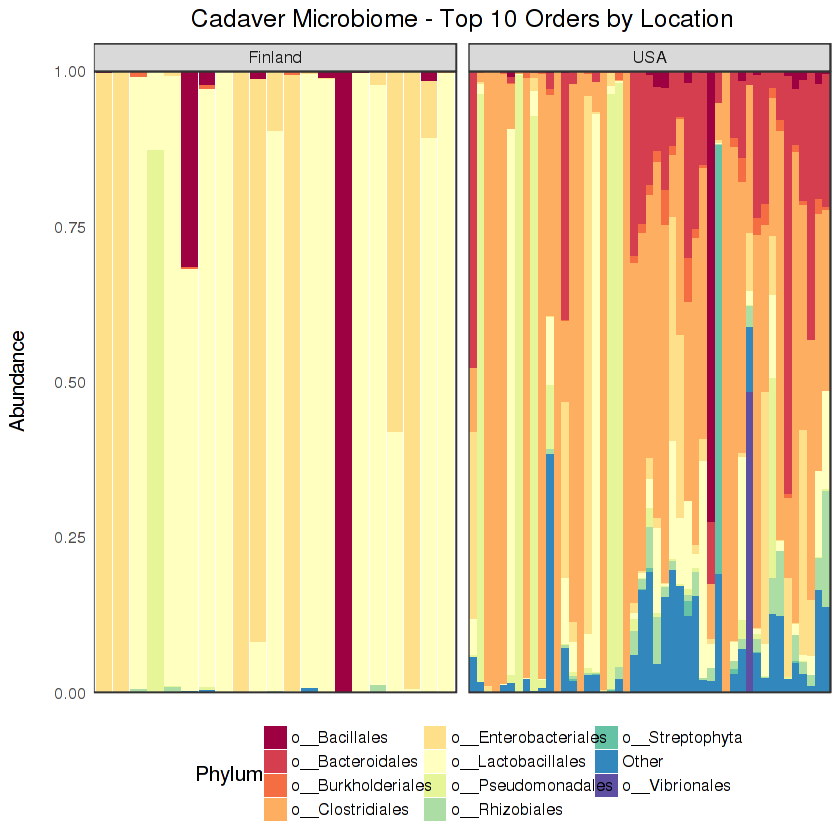

In [147]:
mdf.other$Location <- factor(mdf.other$Location)

p = ggplot(mdf.other, aes(x=Sample, y = Abundance, fill = Rank4.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Phylum", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=12, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              legend.key.size = unit(1, "mm"),
              legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Cadaver Microbiome - Top 10 Orders by Location")

p = p + facet_wrap(~Location, shrink = TRUE, scales = "free_x", ncol=4)

p